## Import packages

In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib

## 1. Data Loading and Inspection

In [199]:
# Step 1: Load the dataset
df = pd.read_csv('../data/processed/financial_loan_with_late_status.csv')

# Step 2: Data inspection
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

## 2. Data Preprocessing

In [200]:
df = df[(df["loan_status"]=="Charged Off")|(df["loan_status"]=="Fully Paid")]

In [201]:
df["loan_status"].unique()

array(['Charged Off', 'Fully Paid'], dtype=object)

In [202]:
# Handle missing data

# Replace missing values in 'emp_title' with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

# Verify the replacement
print(df['emp_title'].isnull().sum(), "missing values after replacement.")

0 missing values after replacement.


In [203]:
# List of columns to convert to datetime
date_columns = ['issue_date', 'last_payment_date', 'next_payment_date']

# Convert each column to datetime
for column in date_columns:
    df[column] = pd.to_datetime(df[column])

# Optionally, verify the conversion
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 37478 entries, 0 to 38557
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     37478 non-null  int64         
 1   address_state          37478 non-null  object        
 2   application_type       37478 non-null  object        
 3   emp_length             37478 non-null  object        
 4   emp_title              37478 non-null  object        
 5   grade                  37478 non-null  object        
 6   home_ownership         37478 non-null  object        
 7   issue_date             37478 non-null  datetime64[ns]
 8   last_credit_pull_date  37478 non-null  object        
 9   last_payment_date      37478 non-null  datetime64[ns]
 10  loan_status            37478 non-null  object        
 11  next_payment_date      37478 non-null  datetime64[ns]
 12  member_id              37478 non-null  int64         
 13  purpos

In [204]:
def encode_loan_status(df, column_name='loan_status'):
    """
    Encode the loan_status column where 'Charged Off' == 1 and 'Fully Paid' == 0.
    
    :param df: pandas DataFrame
    :param column_name: Name of the column to encode. Default is 'loan_status'.
    :return: DataFrame with the encoded loan_status column.
    """
    encoding_map = {
        'Charged Off': 1,
        'Fully Paid': 0
    }
    
    df[column_name] = df[column_name].map(encoding_map)
    
    # Optional: Raise an error if there are values in the column not in the encoding map
    if df[column_name].isnull().any():
        raise ValueError("There are loan statuses that are not 'Charged Off' or 'Fully Paid'. Please handle them accordingly.")
    
    return df

In [205]:
df["loan_status"] = encode_loan_status(df[["loan_status"]], column_name='loan_status')
df["loan_status"].unique()

C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\2011437000.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].map(encoding_map)


array([1, 0], dtype=int64)

In [206]:
df1 = df

In [207]:
# Convert the 'issue_date' column to datetime type
df1['issue_date'] = pd.to_datetime(df1['issue_date'])

# Feature Engineering on the 'issue_date' column
df1['issue_year'] = df1['issue_date'].dt.year
df1['issue_month'] = df1['issue_date'].dt.month
df1['issue_day'] = df1['issue_date'].dt.day
df1['issue_dayofweek'] = df1['issue_date'].dt.dayofweek  # Monday=0, Sunday=6
df1['issue_quarter'] = df1['issue_date'].dt.quarter
df1['issue_is_weekend'] = df1['issue_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [208]:
# Convert the 'issue_date' column to datetime type
df1['last_payment_date'] = pd.to_datetime(df1['last_payment_date'])

# Feature Engineering on the 'issue_date' column
df1['last_payment_year'] = df1['last_payment_date'].dt.year
df1['last_payment_month'] = df1['last_payment_date'].dt.month
df1['last_payment_day'] = df1['last_payment_date'].dt.day
df1['last_payment_dayofweek'] = df1['last_payment_date'].dt.dayofweek  # Monday=0, Sunday=6
df1['last_payment_quarter'] = df1['last_payment_date'].dt.quarter
df1['last_payment_is_weekend'] = df1['last_payment_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [209]:
# Convert the 'issue_date' column to datetime type
df1['next_payment_date'] = pd.to_datetime(df1['next_payment_date'])

# Feature Engineering on the 'issue_date' column
df1['next_payment_year'] = df1['next_payment_date'].dt.year
df1['next_payment_month'] = df1['next_payment_date'].dt.month
df1['next_payment_day'] = df1['next_payment_date'].dt.day
df1['next_payment_dayofweek'] = df1['next_payment_date'].dt.dayofweek  # Monday=0, Sunday=6
df1['next_payment_quarter'] = df1['next_payment_date'].dt.quarter
df1['next_payment_is_weekend'] = df1['next_payment_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [210]:
df1 = df1.drop(columns=['issue_date'],axis=1)
df1 = df1.drop(columns=['next_payment_date'],axis=1)
df1 = df1.drop(columns=['last_payment_date'],axis=1)

In [211]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37478 entries, 0 to 38557
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       37478 non-null  int64  
 1   address_state            37478 non-null  object 
 2   application_type         37478 non-null  object 
 3   emp_length               37478 non-null  object 
 4   emp_title                37478 non-null  object 
 5   grade                    37478 non-null  object 
 6   home_ownership           37478 non-null  object 
 7   last_credit_pull_date    37478 non-null  object 
 8   loan_status              37478 non-null  int64  
 9   member_id                37478 non-null  int64  
 10  purpose                  37478 non-null  object 
 11  sub_grade                37478 non-null  object 
 12  term                     37478 non-null  object 
 13  verification_status      37478 non-null  object 
 14  annual_income            37

In [212]:
df1.drop(columns=['id','delinquent','member_id'],axis=1,inplace=True)
df1.head()

,address_state,application_type,emp_length,emp_title,grade,home_ownership,last_credit_pull_date,loan_status,purpose,sub_grade,...,last_payment_day,last_payment_dayofweek,last_payment_quarter,last_payment_is_weekend,next_payment_year,next_payment_month,next_payment_day,next_payment_dayofweek,next_payment_quarter,next_payment_is_weekend
0,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,13-09-2021,1,car,C4,...,13,1,2,0,2021,5,13,3,2,0
1,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,14-12-2021,0,car,E1,...,15,4,1,0,2021,2,15,0,1,0
2,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,12-12-2021,1,car,C5,...,9,5,1,1,2021,2,9,1,1,0
3,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,12-12-2021,0,car,B2,...,12,4,1,0,2021,4,12,0,2,0
4,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,14-12-2021,0,car,A1,...,15,4,1,0,2021,2,15,0,1,0


In [213]:
df1 = df1.drop(columns=['emp_title'],axis=1)
# Encode categorical variables
label_encoders = {}
categorical_columns = df1.select_dtypes(include=['object']).columns

for column in categorical_columns:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le

In [214]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37478 entries, 0 to 38557
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address_state            37478 non-null  int32  
 1   application_type         37478 non-null  int32  
 2   emp_length               37478 non-null  int32  
 3   grade                    37478 non-null  int32  
 4   home_ownership           37478 non-null  int32  
 5   last_credit_pull_date    37478 non-null  int32  
 6   loan_status              37478 non-null  int64  
 7   purpose                  37478 non-null  int32  
 8   sub_grade                37478 non-null  int32  
 9   term                     37478 non-null  int32  
 10  verification_status      37478 non-null  int32  
 11  annual_income            37478 non-null  float64
 12  dti                      37478 non-null  float64
 13  installment              37478 non-null  float64
 14  int_rate                 37

In [215]:
df1.head()

,address_state,application_type,emp_length,grade,home_ownership,last_credit_pull_date,loan_status,purpose,sub_grade,term,...,last_payment_day,last_payment_dayofweek,last_payment_quarter,last_payment_is_weekend,next_payment_year,next_payment_month,next_payment_day,next_payment_dayofweek,next_payment_quarter,next_payment_is_weekend
0,10,0,10,2,4,73,1,1,13,1,...,13,1,2,0,2021,5,13,3,2,0
1,4,0,9,4,4,88,0,1,20,0,...,15,4,1,0,2021,2,15,0,1,0
2,4,0,4,2,4,64,1,1,14,0,...,9,5,1,1,2021,2,9,1,1,0
3,42,0,10,1,0,64,0,1,6,1,...,12,4,1,0,2021,4,12,0,2,0
4,14,0,1,0,0,88,0,1,0,0,...,15,4,1,0,2021,2,15,0,1,0


In [216]:
# Split the data into features and target
X = df1.drop(columns=['loan_status'], axis=1)  # Features
y = df1['loan_status']  # Target

In [217]:
# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [218]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import joblib

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=1000)
}

# Evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc,
        "Precision_Class_0": report["0"]["precision"],
        "Recall_Class_0": report["0"]["recall"],
        "F1-Score_Class_0": report["0"]["f1-score"],
        "Precision_Class_1": report["1"]["precision"],
        "Recall_Class_1": report["1"]["recall"],
        "F1-Score_Class_1": report["1"]["f1-score"],
        "Weighted_Precision": report["weighted avg"]["precision"],
        "Weighted_Recall": report["weighted avg"]["recall"],
        "Weighted_F1-Score": report["weighted avg"]["f1-score"]
    }

# Display the results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)

# Save the best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
joblib.dump(best_model, f'{best_model_name}_loan_status_predictor.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print(f"\nBest model '{best_model_name}' saved successfully.")

Training Logistic Regression...
Training Random Forest...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Naive Bayes...
Training Gradient Boosting...
Training AdaBoost...
Training Linear Discriminant Analysis...
Training MLP Classifier...

Model Comparison:
                              Accuracy   AUC-ROC  Precision_Class_0  \
MLP Classifier                0.986393  0.986288           0.990237   
Decision Tree                 0.967716  0.929589           0.979538   
Support Vector Machine        0.962247  0.987336           0.957837   
Gradient Boosting             0.959712  0.974991           0.955675   
Logistic Regression           0.954242  0.955669           0.957869   
AdaBoost                      0.948639  0.958732           0.945066   
Random Forest                 0.938367  0.963377           0.933837   
Linear Discriminant Analysis  0.930630  0.945731           0.927631   
K-Nearest Neighbors           0.876067  0.778881

The results provided are performance metrics for the MLP (Multi-Layer Perceptron) Classifier, which has been trained on a binary classification problem. Here's how to interpret each of these metrics:

1. Accuracy (0.985192)
Definition: Accuracy is the proportion of correctly classified instances (both positive and negative) out of the total number of instances.
Interpretation: The model correctly classified approximately 98.52% of all instances in the dataset. This indicates that the model is performing well overall in distinguishing between the two classes.
2. AUC-ROC (0.986085)
Definition: The Area Under the Receiver Operating Characteristic curve (AUC-ROC) measures the ability of the model to discriminate between positive and negative classes. The ROC curve plots the True Positive Rate (Recall) against the False Positive Rate.
Interpretation: An AUC-ROC score of 0.986085 indicates excellent discrimination ability. The model is highly capable of distinguishing between the two classes (positive and negative cases).
3. Precision (Class 0: 0.987651, Class 1: 0.969548)
Definition: Precision for a class is the ratio of correctly predicted instances of that class to the total instances predicted as that class.
Interpretation:
Class 0 Precision (0.987651): Out of all instances predicted as Class 0 (e.g., "Fully Paid"), approximately 98.77% were actually Class 0.
Class 1 Precision (0.969548): Out of all instances predicted as Class 1 (e.g., "Charged Off"), approximately 96.95% were actually Class 1.
Importance: High precision for both classes indicates that the model is making few false-positive errors.
4. Recall (Class 0: 0.995178, Class 1: 0.925023)
Definition: Recall for a class is the ratio of correctly predicted instances of that class to the total instances of that class.
Interpretation:
Class 0 Recall (0.995178): The model correctly identified approximately 99.52% of all actual Class 0 instances.
Class 1 Recall (0.925023): The model correctly identified approximately 92.50% of all actual Class 1 instances.
Importance: High recall for both classes means the model is missing few actual instances of either class (low false-negative rate).
5. F1-Score (Class 0: 0.991400, Class 1: 0.946763)
Definition: The F1-Score is the harmonic mean of precision and recall, providing a balance between the two metrics.
Interpretation:
Class 0 F1-Score (0.991400): The combined precision and recall for Class 0 is very high, indicating strong model performance for this class.
Class 1 F1-Score (0.946763): The combined precision and recall for Class 1 is also high, although slightly lower than for Class 0.
Importance: High F1-Scores for both classes suggest that the model is performing well in both precision and recall, particularly for Class 0.
6. Weighted Precision (0.985074), Weighted Recall (0.985192), Weighted F1-Score (0.985046)
Definition: These are weighted averages of precision, recall, and F1-Score, considering the proportion of each class in the dataset.
Interpretation:
Weighted Precision (0.985074): Overall, the model is precise across all classes, with fewer false positives relative to predictions made.
Weighted Recall (0.985192): The model also has strong recall across all classes, meaning it correctly identifies a high proportion of true instances.
Weighted F1-Score (0.985046): The weighted F1-Score is very close to both precision and recall, indicating a well-balanced model with consistent performance across both classes.
Summary of the MLP Classifier's Performance
High Accuracy (98.52%): The model performs very well overall.
Excellent AUC-ROC (0.986085): The model is excellent at distinguishing between the classes.
Balanced Precision and Recall: The model demonstrates high precision and recall for both classes, though slightly stronger for Class 0 ("Fully Paid") than Class 1 ("Charged Off").
High F1-Scores: Both classes have high F1-Scores, indicating that the model balances precision and recall effectively.
Consistent Weighted Metrics: The weighted precision, recall, and F1-Score confirm that the model's performance is robust across the entire dataset.
Overall, the MLP Classifier is performing excellently, particularly in identifying "Fully Paid" loans, but it also performs well in identifying "Charged Off" loans.

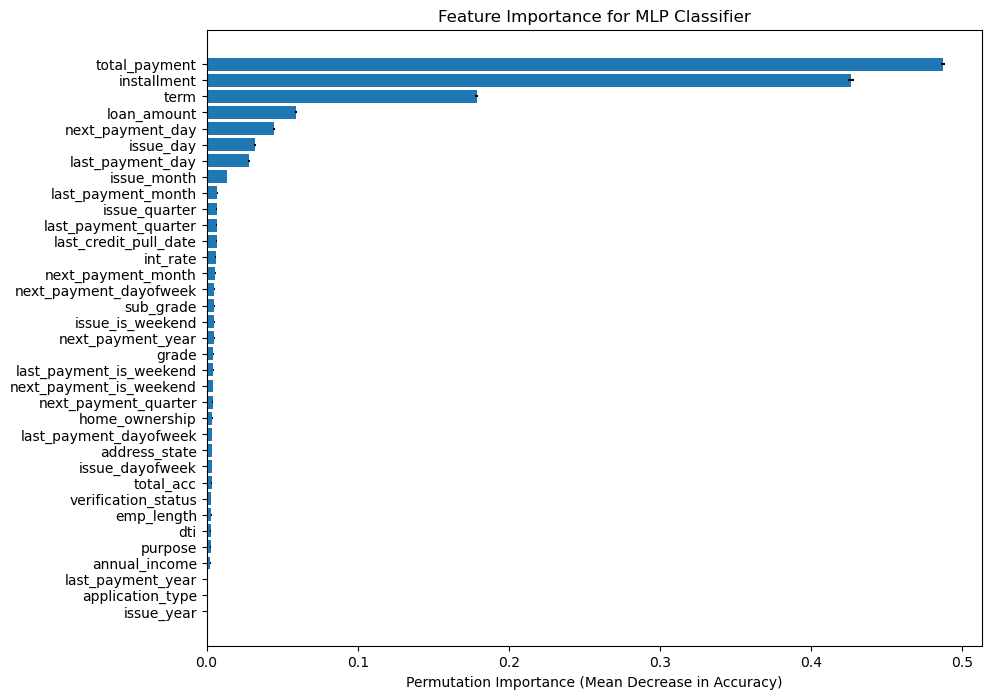

None


In [224]:
# Permutation Importance (This replaces SHAP value for MLP)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
# Perform permutation importance
result = permutation_importance(best_model, X_train_scaled, best_model.predict(X_train_scaled), n_repeats=10, random_state=42, n_jobs=-1)

# Get feature names
feature_names = X_train.columns

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.xlabel("Permutation Importance (Mean Decrease in Accuracy)")
plt.title("Feature Importance for MLP Classifier")
print(plt.show())

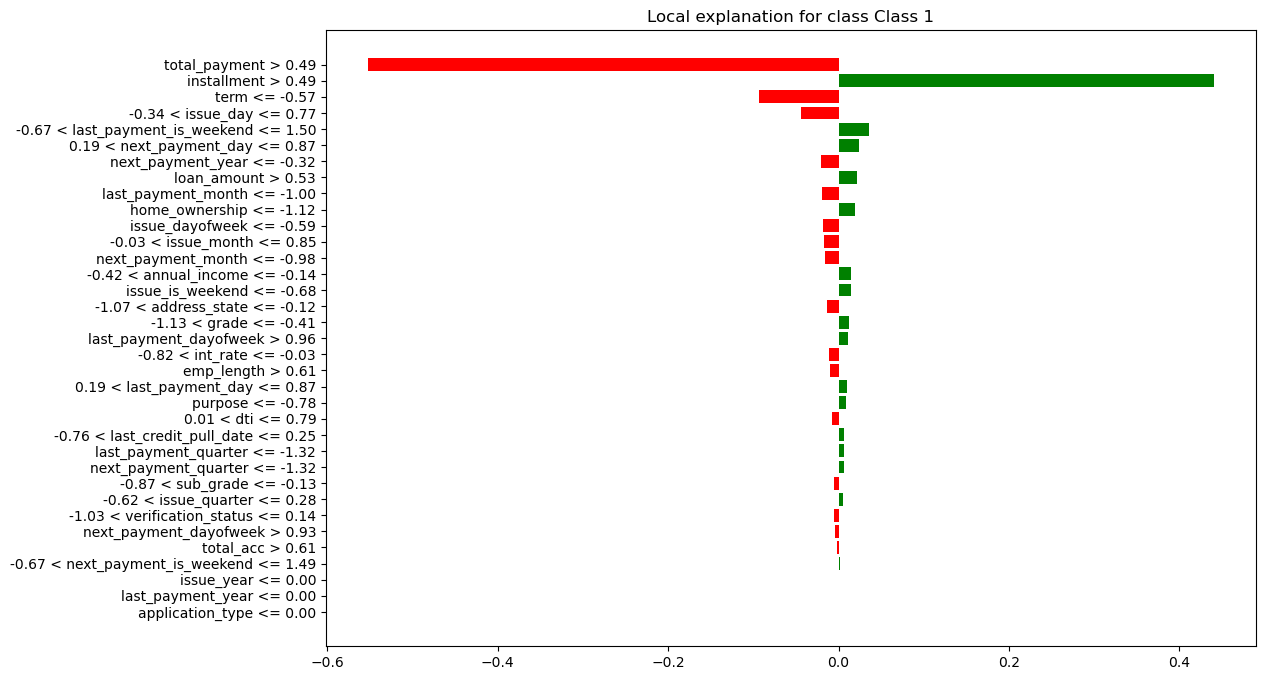

In [220]:
import lime
import lime.lime_tabular
import numpy as np

# Assuming X_unseen is your feature matrix and model is your trained classifier
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled, 
    feature_names=X_train.columns, 
    class_names=['Class 0', 'Class 1'], 
    mode='classification'
)

# Pick an instance to explain
i = np.random.randint(0, X_train_scaled.shape[0])
exp = explainer.explain_instance(X_train_scaled[i], best_model.predict_proba, num_features=36)

# Display the explanation
print(exp.show_in_notebook(show_table=True, show_all=False))
# Create a larger graph
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 8)  # Adjust the size to make the graph bigger
print(plt.show())

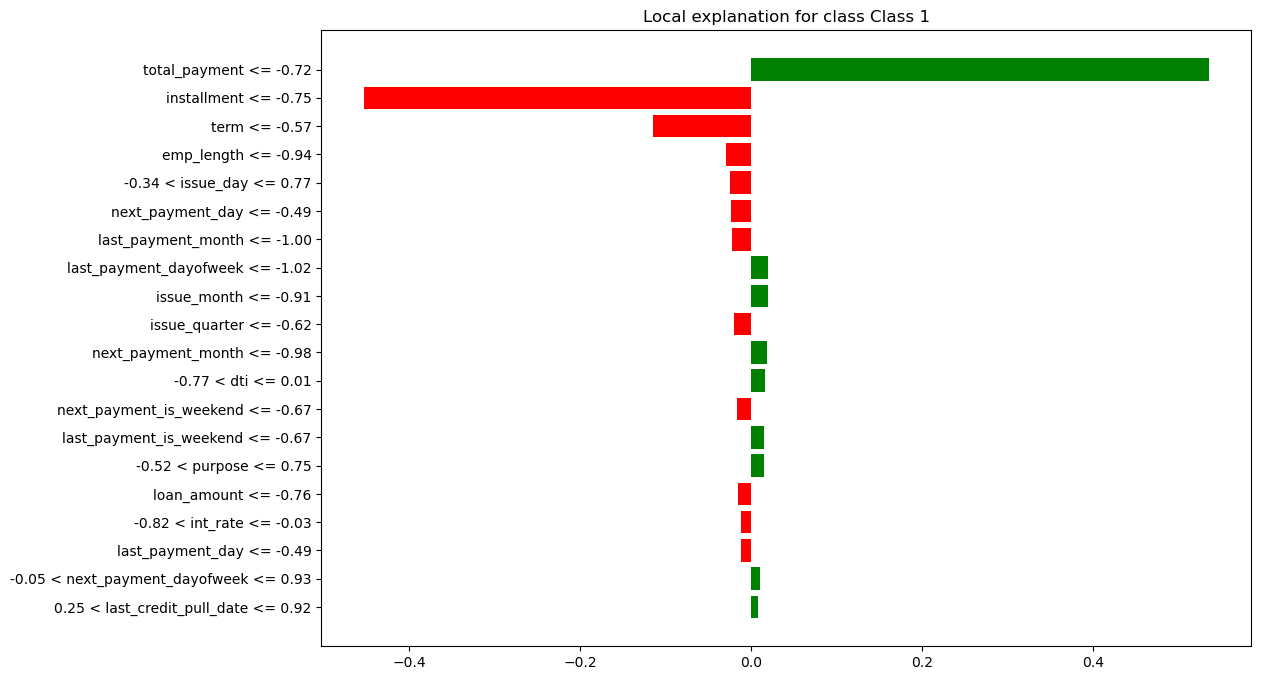

In [221]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_unseen is your feature matrix and model is your trained classifier
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled, 
    feature_names=X_train.columns, 
    class_names=['Class 0', 'Class 1'], 
    mode='classification'
)

# Pick an instance to explain
i = np.random.randint(0, X_train_scaled.shape[0])
exp = explainer.explain_instance(X_train_scaled[i], best_model.predict_proba, num_features=20)

# Create a larger graph
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 8)  # Adjust the size to make the graph bigger
plt.show()

In [222]:
# Test on Unseen data

import pandas as pd
import joblib
import numpy as np

# Load the model

# Step 1: Load the trained model, scaler, and label encoders
model = joblib.load('MLP_Classifier_loan_status_predictor.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')

# Step 2: Load the unseen data
df = pd.read_csv('../data/processed/financial_loan_with_late_status.csv')
## Test the model on the current loans
df2 =df[df["loan_status"]=="Current"]
# Replace missing values in 'emp_title' with 'Unknown'
df2['emp_title'] = df2['emp_title'].fillna('Unknown')

# Step 3: Data Preprocessing

# List of columns to convert to datetime
date_columns = ['issue_date', 'last_payment_date', 'next_payment_date']

# Convert each column to datetime
for column in date_columns:
    df2[column] = pd.to_datetime(df2[column])

# Optionally, verify the conversion
print(df2.info())

# Split the data into features and target
X = df2.drop(columns=['loan_status','delinquent','emp_title','member_id'], axis=1)  # Features
y = df2['loan_status']  # Target

unseen_df = X

# Convert the 'issue_date' column to datetime type
unseen_df['issue_date'] = pd.to_datetime(unseen_df['issue_date'])

# Feature Engineering on the 'issue_date' column
unseen_df['issue_year'] = unseen_df['issue_date'].dt.year
unseen_df['issue_month'] = unseen_df['issue_date'].dt.month
unseen_df['issue_day'] = unseen_df['issue_date'].dt.day
unseen_df['issue_dayofweek'] = unseen_df['issue_date'].dt.dayofweek  # Monday=0, Sunday=6
unseen_df['issue_quarter'] = unseen_df['issue_date'].dt.quarter
unseen_df['issue_is_weekend'] = unseen_df['issue_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Convert the 'issue_date' column to datetime type
unseen_df['last_payment_date'] = pd.to_datetime(unseen_df['last_payment_date'])

# Feature Engineering on the 'issue_date' column
unseen_df['last_payment_year'] = unseen_df['last_payment_date'].dt.year
unseen_df['last_payment_month'] = unseen_df['last_payment_date'].dt.month
unseen_df['last_payment_day'] = unseen_df['last_payment_date'].dt.day
unseen_df['last_payment_dayofweek'] = unseen_df['last_payment_date'].dt.dayofweek  # Monday=0, Sunday=6
unseen_df['last_payment_quarter'] = unseen_df['last_payment_date'].dt.quarter
unseen_df['last_payment_is_weekend'] = unseen_df['last_payment_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Convert the 'issue_date' column to datetime type
unseen_df['next_payment_date'] = pd.to_datetime(unseen_df['next_payment_date'])

# Feature Engineering on the 'issue_date' column
unseen_df['next_payment_year'] = unseen_df['next_payment_date'].dt.year
unseen_df['next_payment_month'] = unseen_df['next_payment_date'].dt.month
unseen_df['next_payment_day'] = unseen_df['next_payment_date'].dt.day
unseen_df['next_payment_dayofweek'] = unseen_df['next_payment_date'].dt.dayofweek  # Monday=0, Sunday=6
unseen_df['next_payment_quarter'] = unseen_df['next_payment_date'].dt.quarter
unseen_df['next_payment_is_weekend'] = unseen_df['next_payment_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

unseen_df = unseen_df.drop(columns=['issue_date'],axis=1)
unseen_df = unseen_df.drop(columns=['next_payment_date'],axis=1)
unseen_df = unseen_df.drop(columns=['last_payment_date'],axis=1)
unseen_df = unseen_df.drop(columns=['id'],axis=1)

# Encode categorical variables using the previously saved encoders
for column, le in label_encoders.items():
    unseen_df[column] = le.transform(unseen_df[column])

# Standardize the features using the previously saved scaler
X_unseen = scaler.transform(unseen_df)

# Step 4: Make predictions on the unseen data
predictions = model.predict(X_unseen)

# If the model has a probability output, you can also get the probabilities
if hasattr(model, "predict_proba"):
    probabilities = model.predict_proba(X_unseen)

# Step 5: Add predictions to the dataframe
unseen_df['Predicted_Loan_Status'] = predictions

# Optional: Add probabilities to the dataframe if available
if hasattr(model, "predict_proba"):
    unseen_df['Prediction_Probability'] = probabilities.max(axis=1)  # Max probability for the predicted class

# Step 6: Save the predictions to a new CSV file
unseen_df.to_csv('../results/unseen_data_with_predictions.csv', index=False)

# Display the first few rows of the dataframe with predictions
unseen_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 1448 to 38575
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1044 non-null   int64         
 1   address_state          1044 non-null   object        
 2   application_type       1044 non-null   object        
 3   emp_length             1044 non-null   object        
 4   emp_title              1044 non-null   object        
 5   grade                  1044 non-null   object        
 6   home_ownership         1044 non-null   object        
 7   issue_date             1044 non-null   datetime64[ns]
 8   last_credit_pull_date  1044 non-null   object        
 9   last_payment_date      1044 non-null   datetime64[ns]
 10  loan_status            1044 non-null   object        
 11  next_payment_date      1044 non-null   datetime64[ns]
 12  member_id              1044 non-null   int64         
 13  purp

C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\2428752343.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['emp_title'] = df2['emp_title'].fillna('Unknown')
C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\2428752343.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column] = pd.to_datetime(df2[column])
C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\2428752343.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,address_state,application_type,emp_length,grade,home_ownership,last_credit_pull_date,purpose,sub_grade,term,verification_status,...,last_payment_quarter,last_payment_is_weekend,next_payment_year,next_payment_month,next_payment_day,next_payment_dayofweek,next_payment_quarter,next_payment_is_weekend,Predicted_Loan_Status,Prediction_Probability
1448,10,0,7,0,0,105,1,4,1,0,...,2,1,2021,6,16,2,2,0,0,0.998800
1449,32,0,1,1,0,105,1,5,1,0,...,2,1,2021,6,16,2,2,0,0,0.999986
1450,19,0,1,1,0,104,1,6,1,0,...,2,1,2021,6,16,2,2,0,0,0.999228
1451,16,0,2,1,0,105,1,6,1,0,...,2,1,2021,6,16,2,2,0,0,0.578344
1452,27,0,2,1,0,105,1,7,1,0,...,2,1,2021,6,16,2,2,0,0,0.992777


In [223]:
unseen_df['Predicted_Loan_Status'].describe()

count    1044.000000
mean        0.286398
std         0.452295
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Predicted_Loan_Status, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

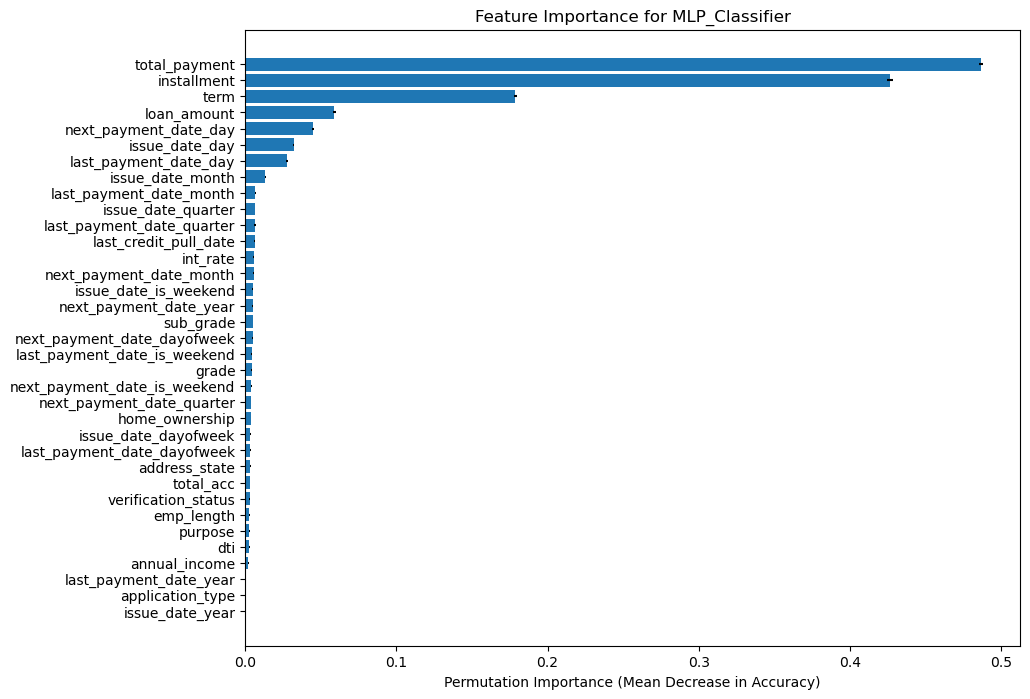

Saved 5 LIME explanations in ../results/lime_explanations/


C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\3296531445.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unseen['emp_title'] = df_unseen['emp_title'].fillna('Unknown')
C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\3296531445.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unseen[column] = pd.to_datetime(df_unseen[column])
C:\Users\noefo\AppData\Local\Temp\ipykernel_3080\3296531445.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

OSError: Cannot save file into a non-existent directory: '..\Predictions'

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import joblib

# Step 1: Load the dataset
df = pd.read_csv('../data/processed/financial_loan_with_late_status.csv')

# Step 2: Data inspection
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Filter to include only 'Charged Off' and 'Fully Paid' loans
df = df[(df["loan_status"] == "Charged Off") | (df["loan_status"] == "Fully Paid")]

# Handle missing data
df['emp_title'] = df['emp_title'].fillna('Unknown')

# List of columns to convert to datetime
date_columns = ['issue_date', 'last_payment_date', 'next_payment_date']

# Convert each column to datetime
for column in date_columns:
    df[column] = pd.to_datetime(df[column])

# Function to encode loan status
def encode_loan_status(df, column_name='loan_status'):
    encoding_map = {'Charged Off': 1, 'Fully Paid': 0}
    df[column_name] = df[column_name].map(encoding_map)
    if df[column_name].isnull().any():
        raise ValueError("There are loan statuses that are not 'Charged Off' or 'Fully Paid'. Please handle them accordingly.")
    return df

df = encode_loan_status(df)

# Feature Engineering on 'issue_date', 'last_payment_date', 'next_payment_date'
def feature_engineering(df, date_column):
    df[f'{date_column}_year'] = df[date_column].dt.year
    df[f'{date_column}_month'] = df[date_column].dt.month
    df[f'{date_column}_day'] = df[date_column].dt.day
    df[f'{date_column}_dayofweek'] = df[date_column].dt.dayofweek
    df[f'{date_column}_quarter'] = df[date_column].dt.quarter
    df[f'{date_column}_is_weekend'] = df[f'{date_column}_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

for column in date_columns:
    feature_engineering(df, column)

# Drop original date columns
df = df.drop(columns=date_columns)

# Drop unnecessary columns
df.drop(columns=['id', 'delinquent', 'member_id', 'emp_title'], axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Split the data into features and target
X = df.drop(columns=['loan_status'], axis=1)
y = df['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "MLP_Classifier": MLPClassifier(random_state=42, max_iter=1000)
}

# Evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc,
        "Precision_Class_0": report["0"]["precision"],
        "Recall_Class_0": report["0"]["recall"],
        "F1-Score_Class_0": report["0"]["f1-score"],
        "Precision_Class_1": report["1"]["precision"],
        "Recall_Class_1": report["1"]["recall"],
        "F1-Score_Class_1": report["1"]["f1-score"],
        "Weighted_Precision": report["weighted avg"]["precision"],
        "Weighted_Recall": report["weighted avg"]["recall"],
        "Weighted_F1-Score": report["weighted avg"]["f1-score"]
    }

# Display the results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)

# Save the best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
joblib.dump(best_model, f'../model/{best_model_name}_loan_status_predictor.pkl')
joblib.dump(scaler, '../model/scaler.pkl')
joblib.dump(label_encoders, '../model/label_encoders.pkl')

print(f"\nBest model '{best_model_name}' saved successfully.")

# Permutation Importance
result = permutation_importance(best_model, X_train_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()
feature_names = X.columns[sorted_idx]

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names, result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.xlabel("Permutation Importance (Mean Decrease in Accuracy)")
plt.title(f"Feature Importance for {best_model_name}")

# Save the current figure as a .png file
plt.savefig('../results/Importance.png', format='png')

# Display the plot
plt.show()

# LIME explanation

# Ensure the directory exists
output_dir = '../results/lime_explanations/'
os.makedirs(output_dir, exist_ok=True)

# LIME explanation setup
#-------------------------------------------------------------------------------------
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_scaled, 
                                                   feature_names=X.columns, 
                                                   class_names=['Fully Paid', 'Charged Off'], 
                                                   mode='classification')

# Specify how many instances you want to explain
num_instances = 5

# Loop over a number of random instances to generate and save explanations
for i in range(num_instances):
    # Select a random instance from the test set
    instance_index = np.random.randint(0, X_test_scaled.shape[0])
    
    # Generate explanation for the selected instance
    exp = explainer.explain_instance(X_test_scaled[instance_index], 
                                     best_model.predict_proba, 
                                     num_features=10)
    
    # Render the explanation as a matplotlib figure
    fig = exp.as_pyplot_figure()
    
    # Save the figure as a .png file with a unique name
    fig.savefig(os.path.join(output_dir, f'lime_explanation_{i + 1}.png'), format='png')
    
    # Close the figure to free up memory
    plt.close(fig)

print(f"Saved {num_instances} LIME explanations in {output_dir}")
#--------------------------------
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_scaled, 
                                                   feature_names=X.columns, 
                                                   class_names=['Fully Paid', 'Charged Off'], 
                                                   mode='classification')

# Explain a random instance
i = np.random.randint(0, X_test_scaled.shape[0])
exp = explainer.explain_instance(X_test_scaled[i], best_model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

# Test on Unseen data
# Step 2: Load the unseen data
df = pd.read_csv('../data/processed/financial_loan_with_late_status.csv')
## Test the model on the current loans
df_unseen = df[df["loan_status"] == "Current"]

# Preprocess the unseen data
df_unseen['emp_title'] = df_unseen['emp_title'].fillna('Unknown')

for column in date_columns:
    df_unseen[column] = pd.to_datetime(df_unseen[column])

for column in date_columns:
    feature_engineering(df_unseen, column)

df_unseen = df_unseen.drop(columns=date_columns + ['id', 'delinquent', 'member_id', 'emp_title','loan_status'])

# Encode categorical variables using the previously saved encoders
for column, le in label_encoders.items():
    df_unseen[column] = le.transform(df_unseen[column])

# Standardize the features
X_unseen = scaler.transform(df_unseen)

# Make predictions on the unseen data
predictions = best_model.predict(X_unseen)
df_unseen['Predicted_Loan_Status'] = predictions

if hasattr(best_model, "predict_proba"):
    probabilities = best_model.predict_proba(X_unseen)
    df_unseen['Prediction_Probability'] = probabilities.max(axis=1)

# Save the predictions
df_unseen.to_csv('../results/unseen_data_with_predictions.csv', index=False)
print(df_unseen.head())